<div class="frontmatter text-center">
<h2> DNDS6013 Scientific Python, Fall 2019 </h2>
<h2> Final Project </h2>
<h2> Felipe Vaca-Ramírez </h2>
</div>

## 1. Outline

The Atmospheric Tomography mission (ATom) is the NASA's airborne world survey of the atmosphere. The mission took flight through Earth's atmosphere to understand how short-lived greenhouse gases like ozone and methane contribute to climate change. Flights originate from California, fly north to the western Arctic, south to the South Pacific, east to the Atlantic, north to Greenland, and return to California across central North America. During each flight, the aircraft executes a continuous series of vertical profiles from 0.2 to 12 km altitude. Further details of the mission can be found at https://espo.nasa.gov/atom/content/ATom.

In this context, my project aims to find differences in the distribution of several gas species of interest. It should be mentioned that, although the corresponding data sets are publicly available at https://daac.ornl.gov/ATOM/campaign/, I have used a data set provided by Julieta Juncosa (Julieta.Juncosa_Calahorrano@colostate.edu), a MS student at the Department of Atmospheric Science, Colorado State University. Besides the measurements for more than 200 species of gases measured by the 24 instruments onboard the NASA DC-8, the data set also contains aircraft flight information, such as latitude, longitude, and altitude. A further description will be provided in section 2.

By observing the conditional distribution of gases, we have noted that some of such distributions depend on altitude layers, seasons, and geographical zones. Specifically, besides finding bimodal distributions, the clustering results showed clear differences between the Northern Hemisphere and the Southern Hemisphere. Once more, I have also colaborated with Julieta to interpret the results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import datetime
import re

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_SDE.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_SDE.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa

## 2. Data

The original data set contains 12234 points and 629 variables, either aircraft flight information (e.g., latitude) or measurements for gases species at a given time and place (e.g., Ozone (O3) measured in parts per billion by volume). A full description of the variables can be found at https://espo.nasa.gov/atom/instruments.

In this project, we focused in two subgroups of variables:

    1. Flight information variables.
        * G_LAT: latitude at which the measurement was done. 
        * G_LONG: longitude at which the measurement was done.
        * G_LAT: altitude (in meters) at which the measurement was done.
        * Solar_Zenith_Angle: Solar Zenith Angle. It can be used as a proxy of hour at which the measurement was done
          to differentiate sunrise and sunset from noon. 
        * campaign: group of months at which the measurements were done. The possible values are: ATom-1 (Jul-Aug 2016), 
        ATom-2 (Jan-Feb 2017), ATom-3 (Sep-Oct 2017), and ATom-4 (Apr-May 2018).
    
    2. Measurements of some gas species: 
        * NOx (Nitrogen Oxides include Nitrogen Monoxide (NO) and Nitrogen Dioxide(NO2)) = NO2_CL + NO_CL; (both in ppbv). 
        NOx is an combustion tracer and often related to anthropogenic activities and fresh wildfire plumes. 
        * CO = 1/2 (CO_NOAA + CO_QCLS); CO is the average of measurements of carbon monoxide using two different instruments
        (measured in ppb). Carbon Monoxide is also a combustion tracer and related to anthropogenic activities and fresh 
        wildfire plumes but it has a longer lifetime in the atmosphere. 
        
        * O3_CL; ozone (in ppbv). Secondary pollutant, produced by photolysis of NO2.
        * PAN_PECD; (in ppt).  Peroxyacetil Nitrate (CH3COO2NO2). Secondary pollutant with temperature stability, its 
        precursors are acetaldehyde and NO2.      
        * HNO3_CIT; (in pptv). Nitric acid. Formed by oxidation of NO2 with OH.
        * BC_mass_90_550_nm; Black Carbon (in ng std m-3). High concentration may be caused by combustion and wildfires.
        * OA_PM1_AMS; (in ug sm-3) Organic Aerosols with diameter less than 1 micron. Anthropogenic, wildfire and 
        vegetation tracer. 
        
        The next five are oil and gas industry tracer and precursors for acetone and acetaldehyde.
        * Propane_TOGA, (in ppt) C3H8
        * iButane_TOGA, (in ppt) C4H10
        * nButane_TOGA, (in ppt) C4H10
        * iPentane_TOGA, (in ppt) C5H12
        * nPentane_TOGA, (in ppt) C5H12
        * Isoprene_TOGA, (in ppt) C5H8. Tracer for Biogenic activity. 
        * Benzene_TOGA, (in ppt) C6H6. Tracer for oil and gas activities. 
        * Toluene_TOGA, (in ppt) C7H8. Tracer for oil and gas activities  (this looks weird, probably the instrument was 
        having problems.
        * Acetone_TOGA, (in ppt) C3H6O. Comes from the oxidation of the above. Most abundant ketone in the atmosphere and
        precursor for PAN, O3.
        * MEK_TOGA, (in ppt). Methyl Ethyl Ketone (C4H8O). 
        * HCN_TOGA, (in ppt). Hydrogen Cyanide. Indicator of wildfires and also toxic.
        * CH3CN_TOGA, (in ppt). Acetonitrile. Indicator of wildfires.
        
    The suffixes CIT, AMS, and TOGA correspond to the instrument used of measure.

In [2]:
# Load data
df = pd.read_csv('ATom_ALL_Data.csv')

In [3]:
# Create date time object and campaign. There is a correspondence between each campaign and the seasons of Northern Hemisphere: 
# ATom-1 (Jul-Aug 2016), ATom-2 (Jan-Feb 2017), ATom-3 (Sep-Oct 2017), and ATom-4 (Apr-May 2018)
dates = []
campaigns = []
for x in df['UTC_Start'].values:
    d = datetime.datetime(year=int(x[:4]), month=int(x[5:7]), day=int(x[8:10]), hour = int(x[11:13]), minute = int(x[14:16]), second = int(x[17:19]))
    dates.append(d)
    
    if d.month in [7,8]: campaigns.append('ATom-1')
    if d.month in [1,2]: campaigns.append('ATom-2')
    if d.month in [9,10]: campaigns.append('ATom-3')
    if d.month in [4,5]: campaigns.append('ATom-4')
    
df['date_time'] = dates
df['campaign'] = campaigns

## 3. Data Analysis

### 3.1. Airflight identification

The first task consisted on briefly exploring the flight tracks identification variables in order to detect possible biases in the sampling procedure.

In [4]:
df['campaign'].value_counts(dropna = False)

ATom-3    3389
ATom-4    3311
ATom-2    2833
ATom-1    2701
Name: campaign, dtype: int64

In [5]:
# Define Northern and Southern Hemispheres
def h(x):
    if x > 0: return('N')
    else: return ('S')
    
df['hemisphere'] = df['G_LAT'].apply(lambda x: h(x))

In [6]:
# Create list of airflight identification variables
vi =  ['campaign', 'hemisphere', 'G_LAT', 'G_LONG', 'G_ALT','Solar_Zenith_Angle']
np.round(df[vi].describe())

G_LAT   G_LONG    G_ALT  Solar_Zenith_Angle
count  12168.0  12168.0  12168.0             12167.0
mean      10.0    -79.0   6863.0                58.0
std       46.0     91.0   3806.0                24.0
min      -86.0   -180.0     41.0                 4.0
25%      -33.0   -146.0   3491.0                41.0
50%       18.0   -110.0   7953.0                57.0
75%       49.0    -32.0  10057.0                73.0
max       83.0    180.0  13200.0               140.0

At first, we note there is no relation between altitude and latitude and longitude. Second, there exists multimodality in several of these distributions. Specifically, altitude exhibits an interesting behaviour, which aligns with the mission goals of sampling the atmosphere near the marine bousary layer and the free troposphere as well as profiling it. We divide our analysis on several layers of altitude, namely: the boundary layer (0-2.5 km), the upper (free) troposphere (2.5-7.5 km), and air traffic layer (> 7.5 km). These categories will be used in the following. There are no clear relations between the solar zenith angle and other variables.

C:\Users\Felipe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Felipe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


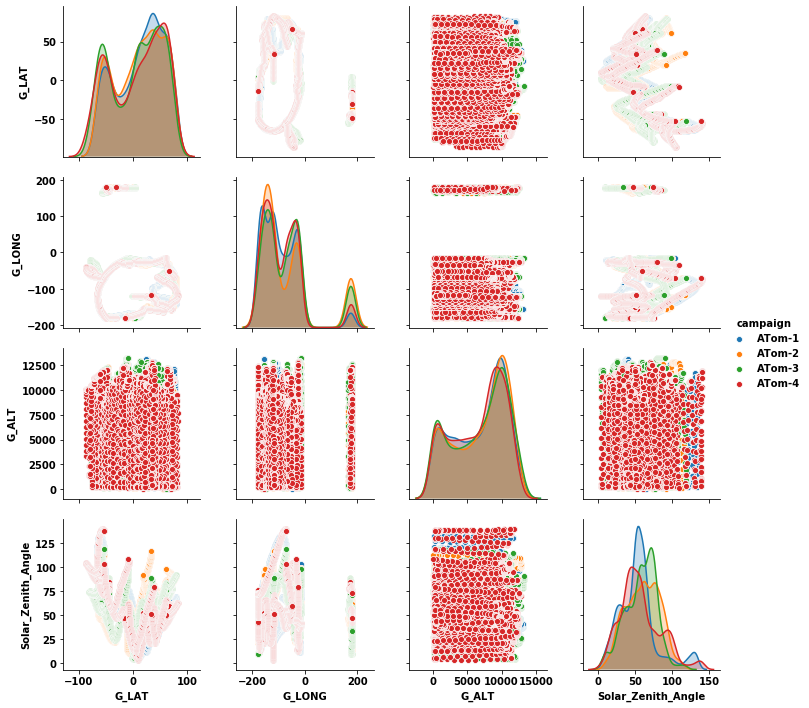

In [7]:
# Plot them
sns.pairplot(df, vars = vi[2:], hue = 'campaign', diag_kind='kde');

In [8]:
# Make altitude categorical
def altitude_class(x):
    if x <= 2500:
        return('0-2.5 km')    
    if x > 2500 and x <= 7500:
        return('2.5-7.5 km')
    if x > 7500:
        return('>7.5 km')
df['ALT_CAT'] = df['G_ALT'].apply(lambda x: altitude_class(x))
df['ALT_CAT'].value_counts()

>7.5 km       6448
2.5-7.5 km    3318
0-2.5 km      2402
Name: ALT_CAT, dtype: int64

The points of measurement are also displayed in the following map. As before, there seems to be a fair overlap between the
between different layers in terms of the places where measurements were done.

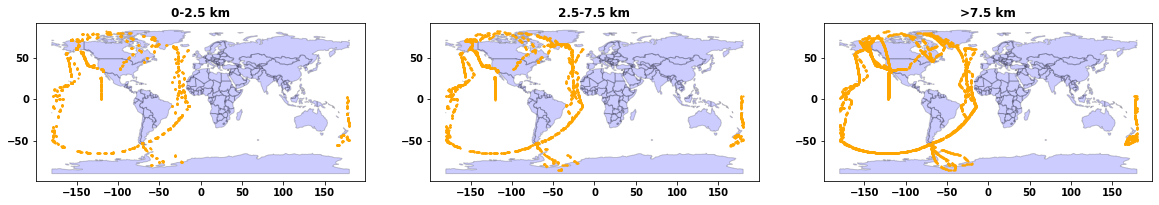

In [9]:
# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a geodataframe of points
from shapely.geometry import Point
gdf = gpd.GeoDataFrame(df, geometry = df.apply(lambda row: Point(row['G_LONG'], row['G_LAT']), axis=1))

from matplotlib.cm import get_cmap
colors = ['b','g','r','m']

cs = sorted(df['ALT_CAT'].unique()[df['ALT_CAT'].unique() != None])
fig, ax = plt.subplots(1,3,figsize = (20,15))
for i,c in enumerate(cs):    
    ax[i].set_aspect('equal')
    world.plot(ax=ax[i],  color='blue', edgecolor='black', alpha = 0.2)
    gdf[df['ALT_CAT'] == c].plot(ax=ax[i], marker='.', markersize=5, color ="orange")
    ax[i].set_title(c)

A map per campaign is also included below. There are some differences in the sampled places, specially in the Northern Hemisphere.

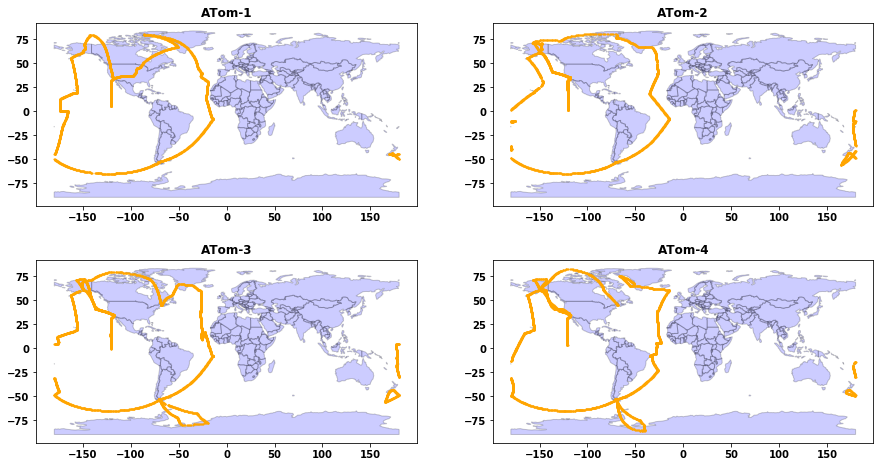

In [10]:
cs = np.unique(df['campaign'])
fig, ax = plt.subplots(2,2,figsize = (15,8))
for i,c in enumerate(cs):
    ax[int(i>1),i%2].set_aspect('equal')
    world.plot(ax=ax[int(i>1),i%2], color='blue', edgecolor='black', alpha = 0.2)
    gdf[df.campaign == c].plot(ax=ax[int(i>1),i%2], marker='.', markersize=5, color ="orange")
    ax[int(i>1),i%2].set_title(c)

### 3.2. Variables containing measurements of gas species

We skip those variables which either contain very few non-missing data (e.g. 'Isoprene_TOGA' and 'DMS_TOGA') or have a high linear relation with other variables (e.g. 'iButane_TOGA.x','nButane_TOGA.x').

In [11]:
# Compute NOx and CO average
df['NOx'] = df['NO2_CL'] + df['NO_CL']
df['CO'] = 0.5 * (df['CO_NOAA'] + df['CO_QCLS'])

vc2 = ['PAN_PECD', 'Propane_TOGA.x','iPentane_TOGA.x',
       'Benzene_TOGA.x','Toluene_TOGA.x','Acetone_TOGA.x',
       'MEK_TOGA.x','HCN_TOGA.x','CH3CN_TOGA.x']

# Gases in ppt units are transformed to ppb units.
for v in vc2:
    df[re.sub('.x', '',v)+'_ppb'] = df[v]/1000

# Abbreviate names    
vc1 = ['NOx', 'CO', 'O3_CL','BC_mass_90_550_nm', 'OA_PM1_AMS'] + [re.sub('.x', '',v)+'_ppb' for v in vc2]
vc = [re.sub('\_.+','',v) for v in vc1]
for k in range(len(vc1)):
    df[vc[k]] = df[vc1[k]]


# Summarize
np.round(df[vc].describe(),3)

NOx        CO         O3         BC        OA       PAN  \
count  10863.000  8958.000  12106.000  10280.000  8698.000  4100.000   
mean       0.067    80.020     80.161     16.586     0.249     0.105   
std        0.199    31.125    109.157     93.900     0.661     0.117   
min       -0.030    16.150      3.294      0.000    -0.141    -0.002   
25%        0.021    59.009     32.455      0.304     0.056     0.024   
50%        0.037    76.768     46.112      1.507     0.115     0.066   
75%        0.069   100.088     70.942      7.285     0.231     0.144   
max       13.921   335.976    917.660   2258.554    12.435     1.188   

        Propane  iPentane    Benzene   Toluene    Acetone       MEK  \
count  9136.000  3112.000  11149.000  7706.000  10734.000  7308.000   
mean      0.121     0.021      0.015     0.201      0.386     0.021   
std       0.194     0.036      0.024     0.370      0.371     0.030   
min       0.010     0.002      0.000     0.000      0.005     0.000   
25%       0.027     0.004      0.003     0.000      0.145     0.005   
50%       0.052     0.009      0.007     0.001      0.277     0.011   
75%       0.138     0.023      0.017     0.018      0.512     0.024   
max       3.628     0.472      0.235     0.999      4.631     0.524   

             HCN      CH3CN  
count  11437.000  11679.000  
mean       0.173      0.114  
std        0.127      0.059  
min        0.005      0.007  
25%        0.090      0.073  
50%        0.149      0.110  
75%        0.222      0.144  
max        1.720      0.911

The cleaning procedure started with eliminating the negative measurements. We also skipped two outliers related with NOx since there are no certainty about the validity of such values.

In [12]:
# Eliminate negative values
for v in vc:
    df[v][df[v] < 0] = np.nan

# Eliminate outliers
df.NOx[df['NOx'] > 5] = np.nan

len(df)

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


12234

The distribution of the majority of the variables is skewed to the right, which suggests the existence of high concentrations of gases in some places. Furthermore, there are potential relations whose interpretations will be postponed one step. 

C:\Users\Felipe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Felipe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


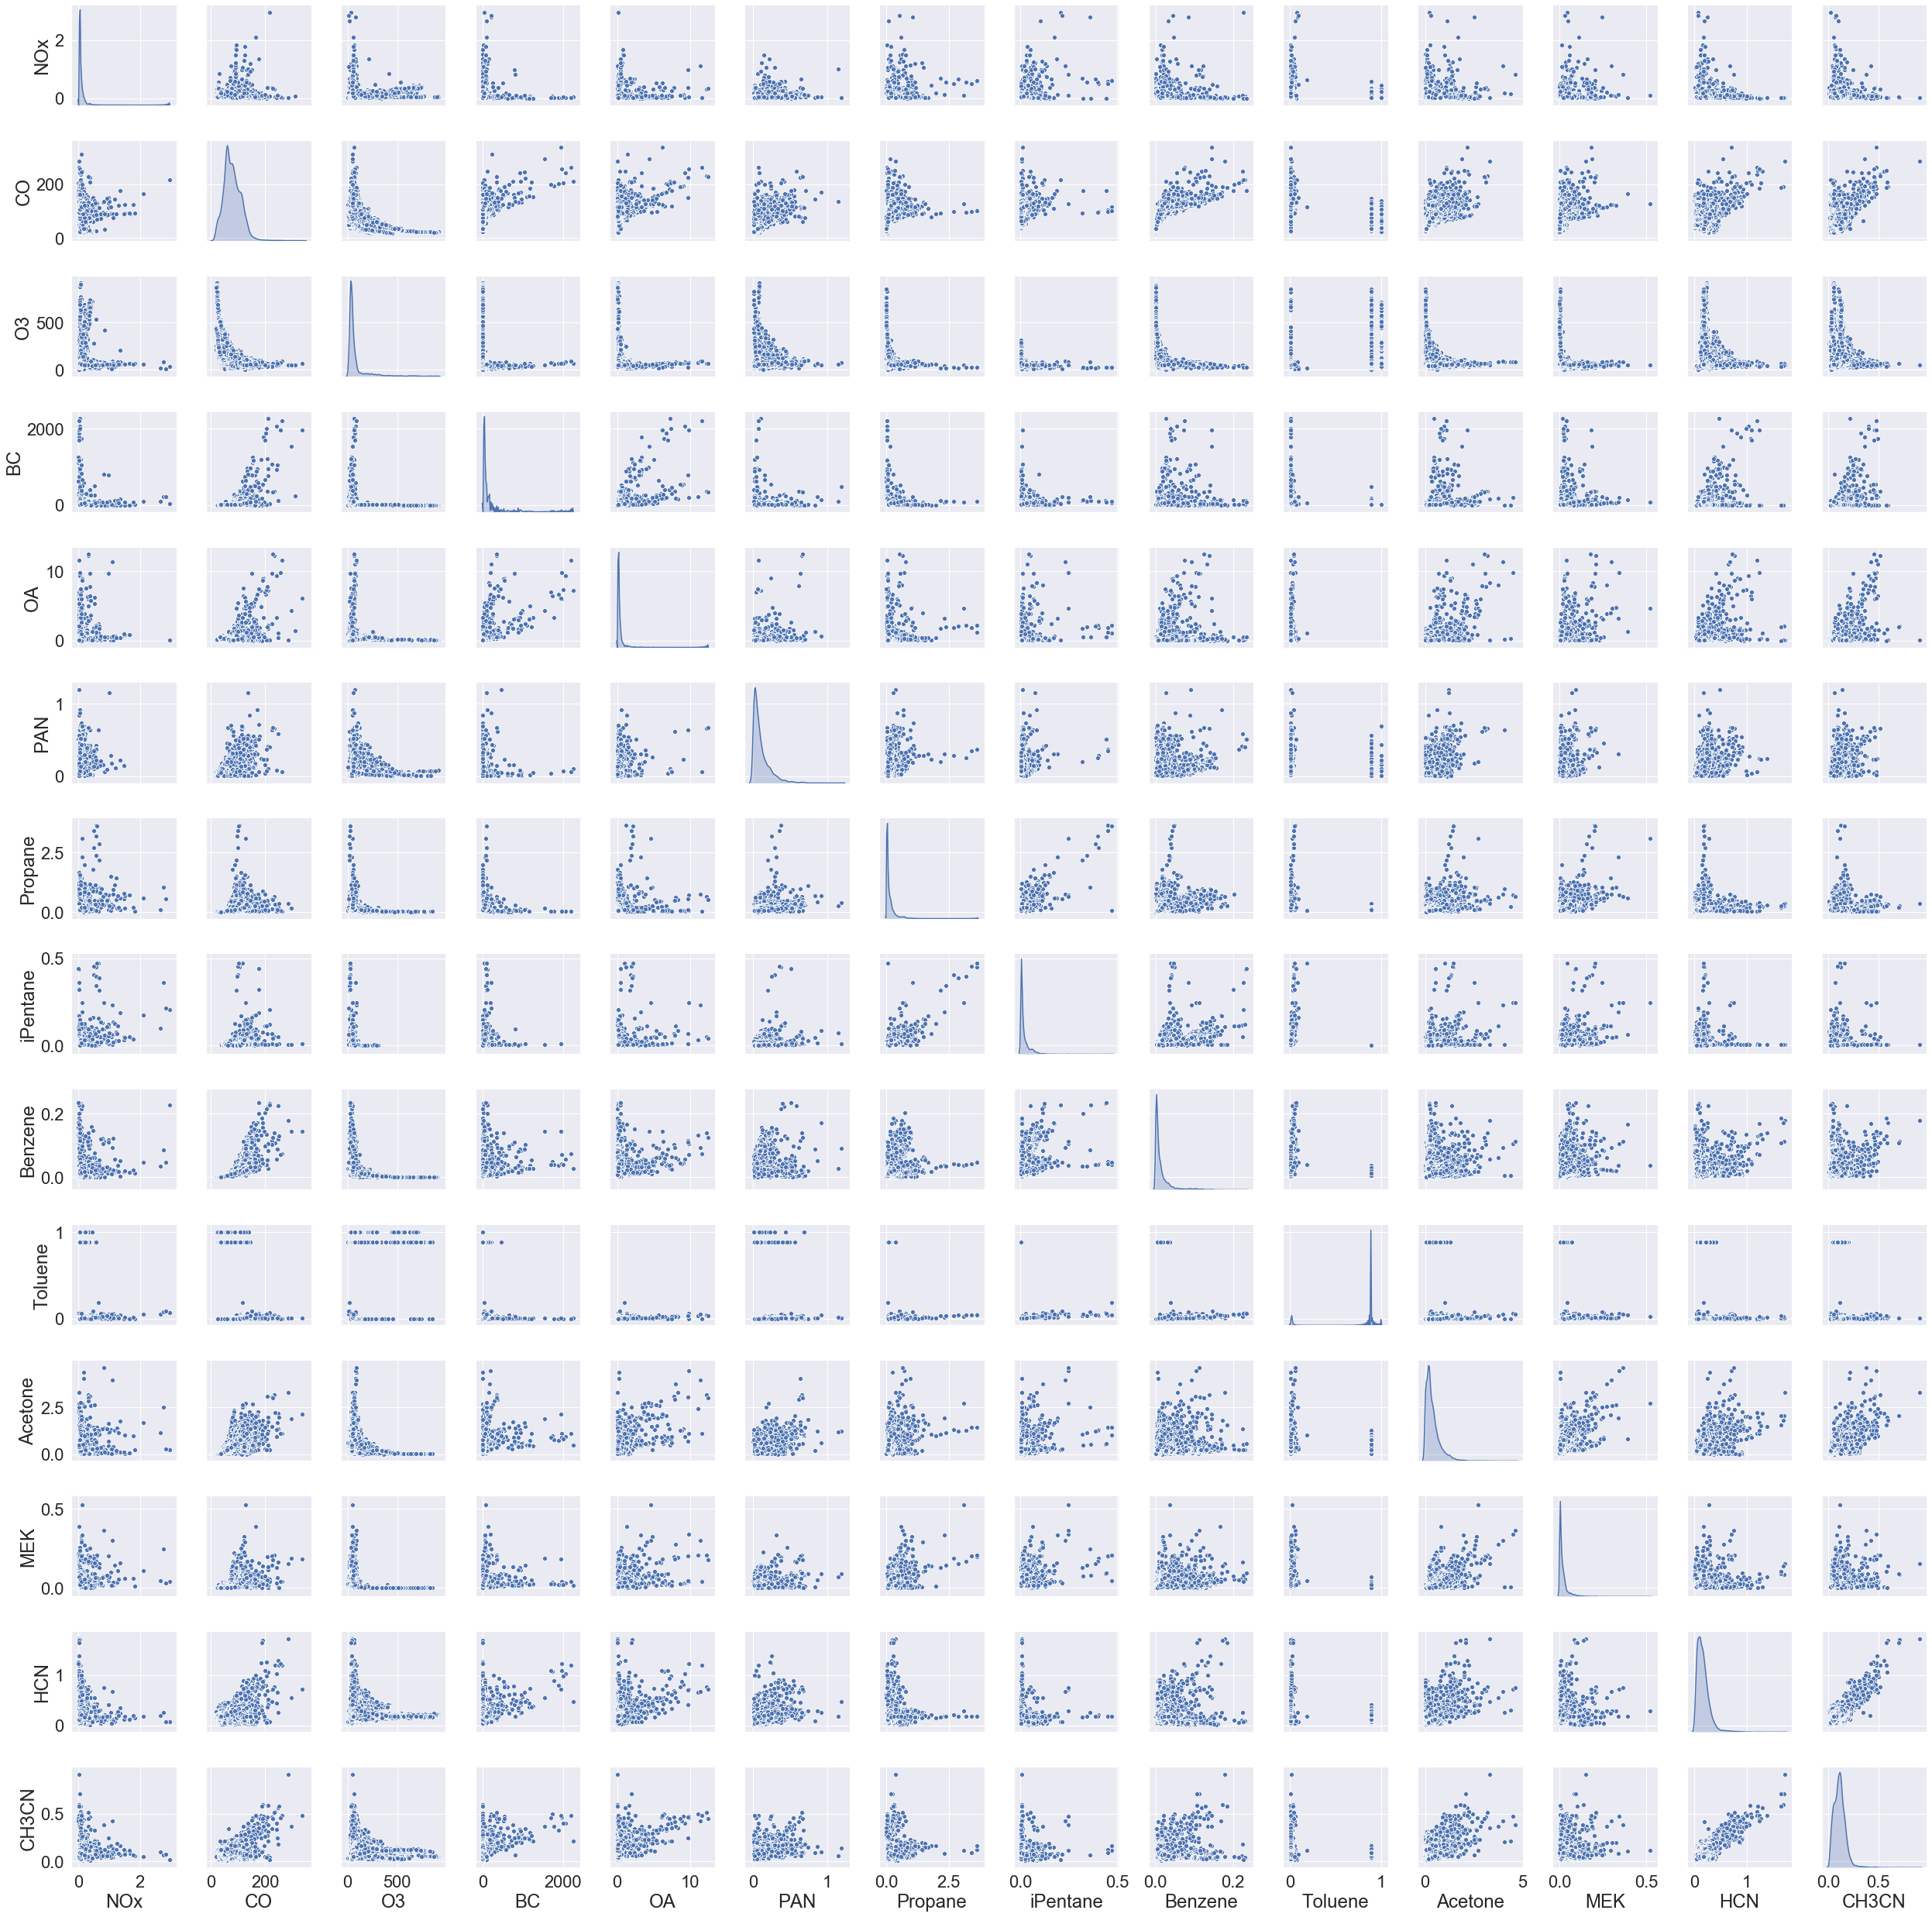

In [13]:
# Create the pairplot
sns.set(font_scale=2)
sns.pairplot(df[vc], diag_kind='kde');

Because of the skewed distributions, we plot the logarithm of the variables of interest. At first, it is possible to note that the distributions of the logs of the variables tend to be more symmetric (with the exception of Toluene). This may be due to instrument limitations (e.g. detection limits, pressure dependece) . Furthermore, some linear relations become clearer. To name some: 

* Negatives relations between CO and O3 (these air masses can either be dark limiting photochemistry or rich in radicals that consume O3) and positive relations between CO and the other remaining variables (except NOx). 
* Negative relations between O3 and Acetone and MEK, and positive relations between O3 and HCN. Acetone and MEK are Ozone precursor. 
* Positive relations between BC and OA, HCN, and CH3CN. All these are fire emitted compounds and expected to be positively correlated.
* Positive relations between PAN with all others. It is not clear what is the reason for this behaviour. 

In [14]:
# Compute the logarithm of variables of interest
log_vc = ['l_'+v for v in vc]
for i in range(len(vc)):
    df[log_vc[i]] = np.log(df[vc[i]].values)  
    
df[log_vc] = df[log_vc].replace([np.inf, -np.inf], np.nan) 

C:\Users\Felipe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


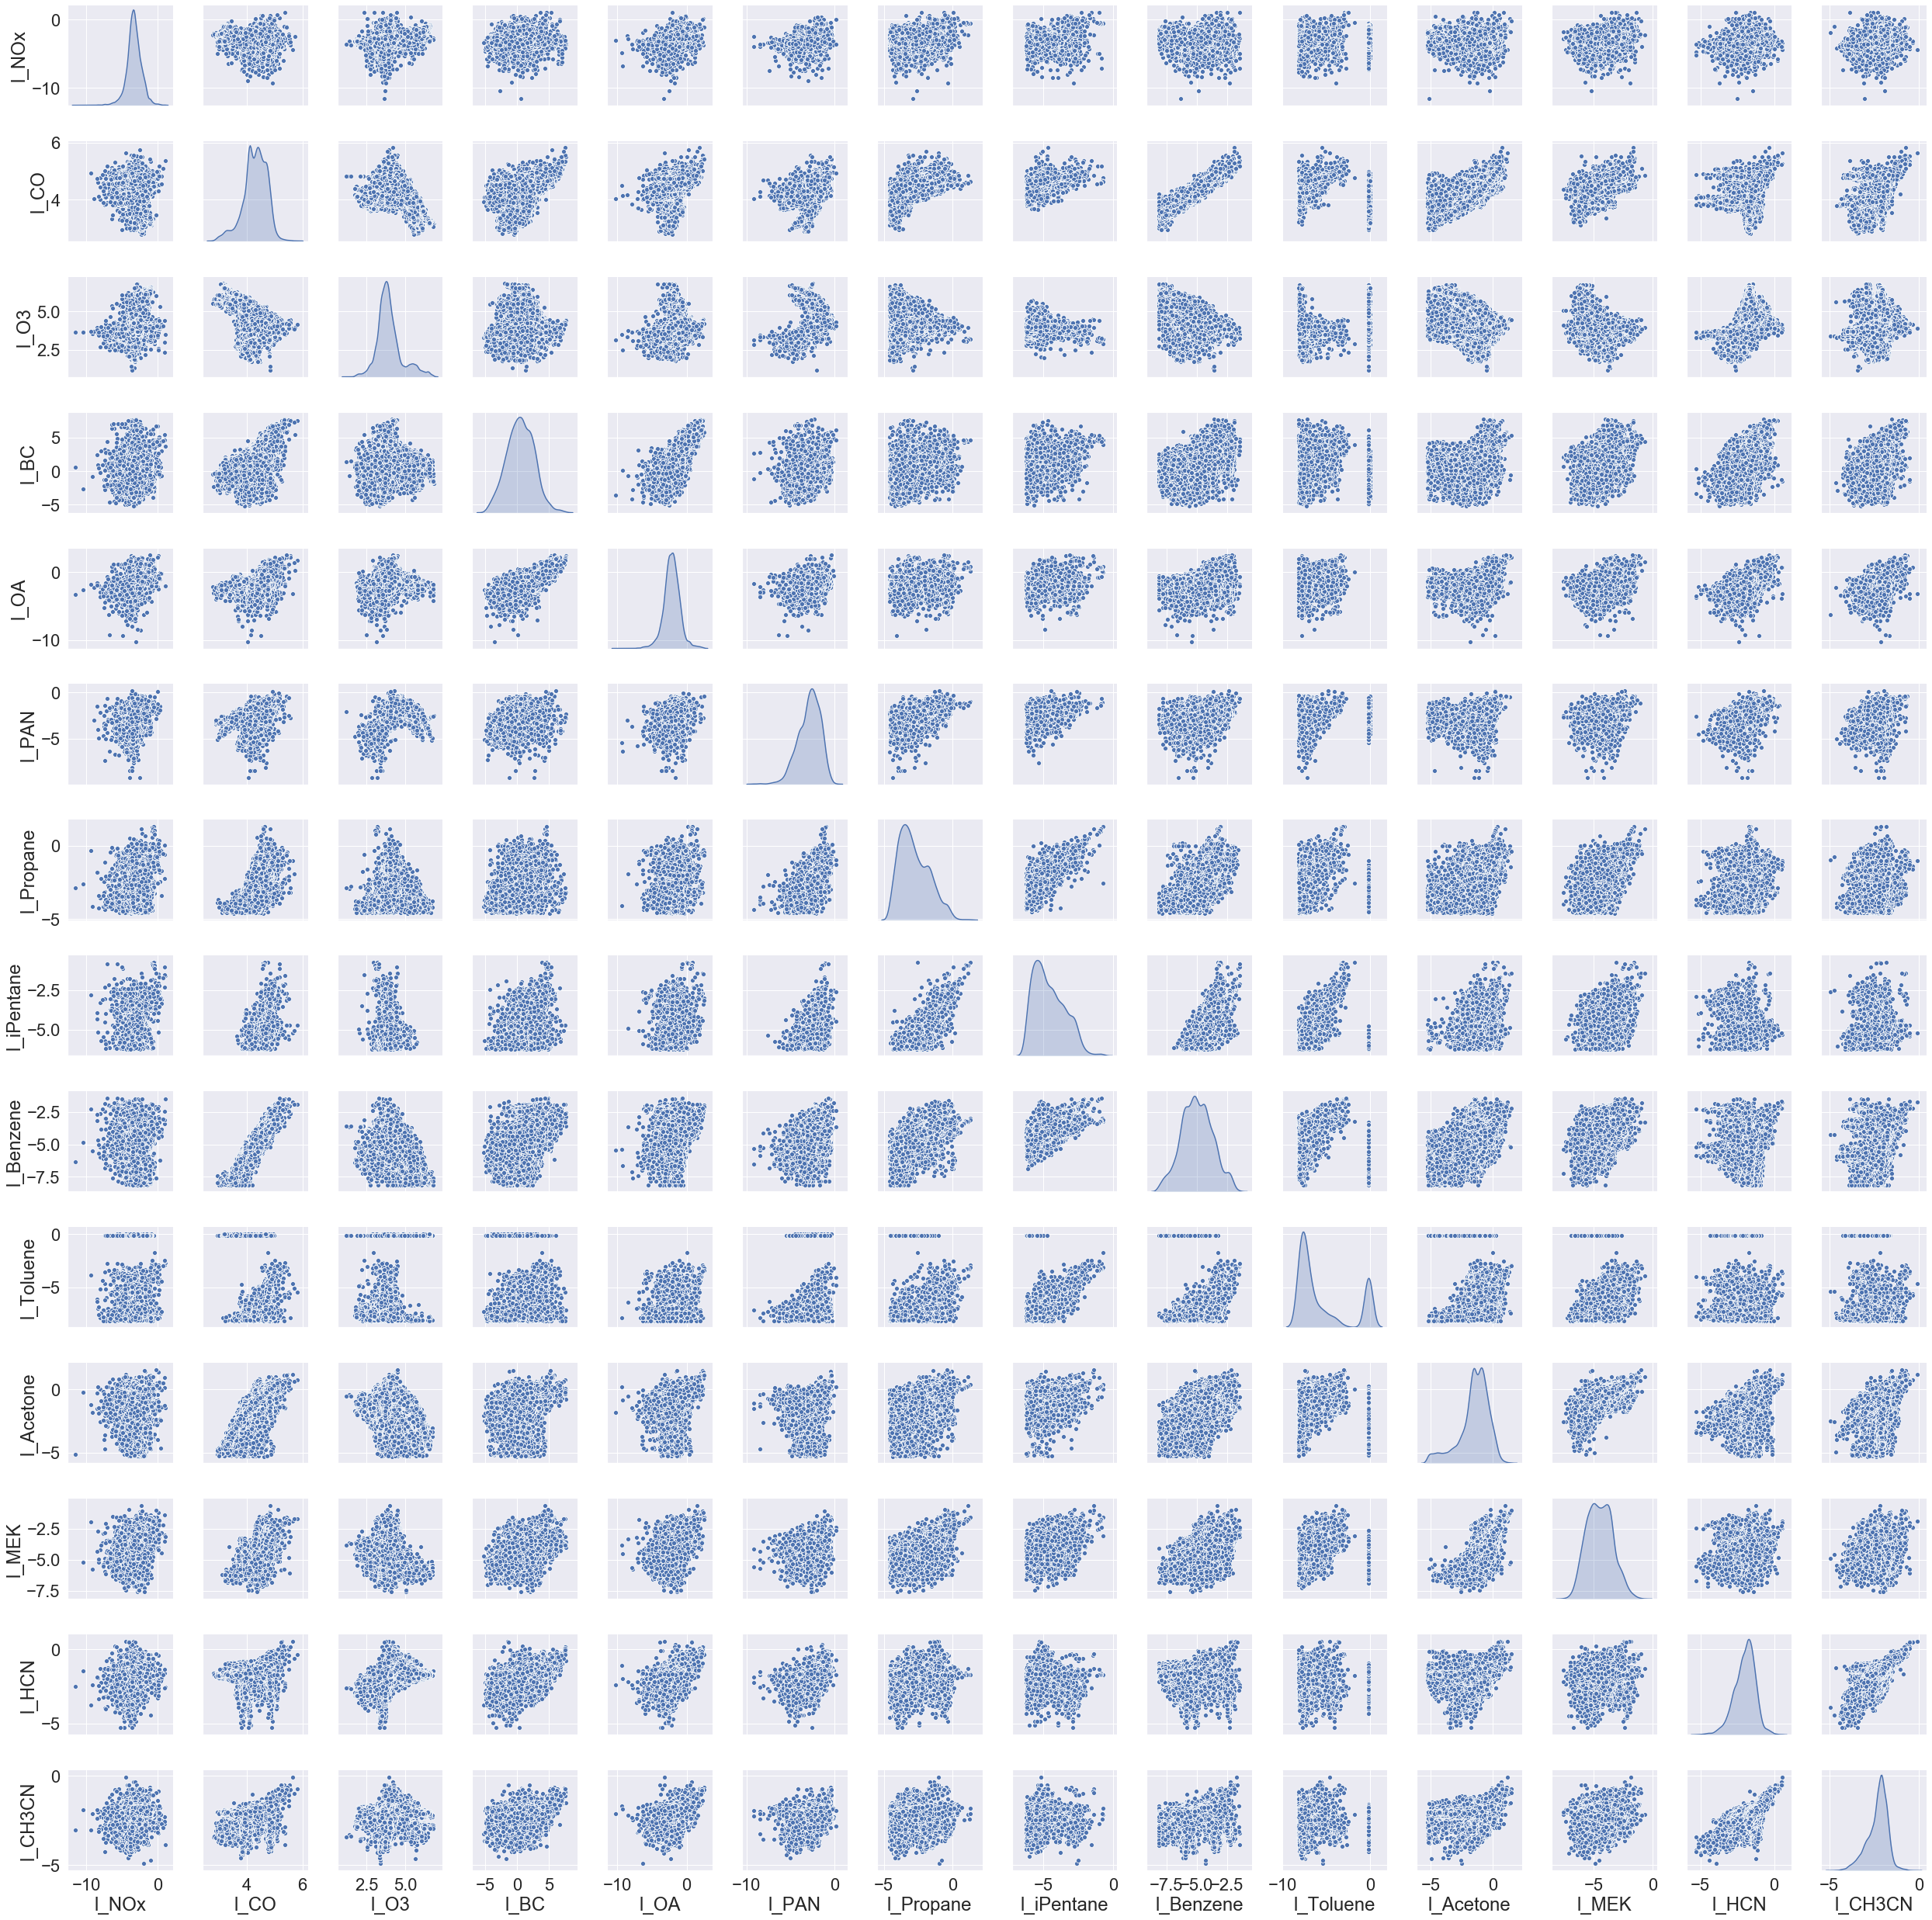

In [15]:
sns.set(font_scale=2)
sns.pairplot(df[log_vc], diag_kind = 'kde');

Furthermore, hypothesis tests on the significance of such correlations were run (Note that,**it may take a while to yield an output!**). Despite the distributions of the logarithm of variables tend to be symmetric in most of the cases, we consider a non parametric test, namely the Test on Kendall's Tau (the null hypothesis is no linear relation). The tables below contain the correlation coefficient values and their corresponding p-values. The results support our claims based on the previous scatterplot. Nevertheless, it should be noted that the correlation values are at most 0.6.

In [16]:
from scipy.stats import pearsonr, kendalltau

kendall_tau = pd.DataFrame(columns = log_vc, index=log_vc, dtype = float)
pvalue = pd.DataFrame(columns = log_vc, index=log_vc, dtype = float)

for i in range(len(log_vc)-1):
    for j in range(i+1,len(log_vc)):
        res = kendalltau(x = df[log_vc[i]],y = df[log_vc[j]], nan_policy='omit')
        kendall_tau.at[log_vc[i],log_vc[j]] = res[0]
        pvalue.at[log_vc[i],log_vc[j]] = res[1]

In [17]:
kendall_tau.round(3)

l_NOx   l_CO   l_O3   l_BC   l_OA  l_PAN  l_Propane  l_iPentane  \
l_NOx         NaN -0.018  0.337  0.076  0.252  0.211      0.078      -0.043   
l_CO          NaN    NaN  0.015  0.305  0.218  0.355      0.532       0.340   
l_O3          NaN    NaN    NaN  0.175  0.321  0.413      0.217      -0.092   
l_BC          NaN    NaN    NaN    NaN  0.419  0.263      0.221       0.042   
l_OA          NaN    NaN    NaN    NaN    NaN  0.357      0.137      -0.053   
l_PAN         NaN    NaN    NaN    NaN    NaN    NaN      0.418       0.155   
l_Propane     NaN    NaN    NaN    NaN    NaN    NaN        NaN       0.565   
l_iPentane    NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_Benzene     NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_Toluene     NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_Acetone     NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_MEK         NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_HCN         NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   
l_CH3CN       NaN    NaN    NaN    NaN    NaN    NaN        NaN         NaN   

            l_Benzene  l_Toluene  l_Acetone  l_MEK  l_HCN  l_CH3CN  
l_NOx          -0.013      0.076      0.003  0.031  0.222    0.098  
l_CO            0.735      0.043      0.450  0.439  0.195    0.222  
l_O3            0.078      0.173      0.073  0.061  0.425    0.097  
l_BC            0.295      0.074      0.249  0.325  0.259    0.096  
l_OA            0.155      0.097      0.194  0.219  0.393    0.216  
l_PAN           0.276      0.066      0.316  0.230  0.409    0.224  
l_Propane       0.554      0.105      0.327  0.415  0.141    0.129  
l_iPentane      0.432      0.491     -0.036  0.169 -0.094   -0.112  
l_Benzene         NaN      0.144      0.361  0.417  0.075    0.089  
l_Toluene         NaN        NaN     -0.032  0.054 -0.003   -0.110  
l_Acetone         NaN        NaN        NaN  0.424  0.294    0.309  
l_MEK             NaN        NaN        NaN    NaN  0.123    0.046  
l_HCN             NaN        NaN        NaN    NaN    NaN    0.477  
l_CH3CN           NaN        NaN        NaN    NaN    NaN      NaN

In [18]:
pvalue.round(5)

l_NOx     l_CO     l_O3  l_BC  l_OA  l_PAN  l_Propane  l_iPentane  \
l_NOx         NaN  0.01679  0.00000   0.0   0.0    0.0        0.0     0.00063   
l_CO          NaN      NaN  0.03419   0.0   0.0    0.0        0.0     0.00000   
l_O3          NaN      NaN      NaN   0.0   0.0    0.0        0.0     0.00000   
l_BC          NaN      NaN      NaN   NaN   0.0    0.0        0.0     0.00216   
l_OA          NaN      NaN      NaN   NaN   NaN    0.0        0.0     0.00022   
l_PAN         NaN      NaN      NaN   NaN   NaN    NaN        0.0     0.00000   
l_Propane     NaN      NaN      NaN   NaN   NaN    NaN        NaN     0.00000   
l_iPentane    NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_Benzene     NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_Toluene     NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_Acetone     NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_MEK         NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_HCN         NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   
l_CH3CN       NaN      NaN      NaN   NaN   NaN    NaN        NaN         NaN   

            l_Benzene  l_Toluene  l_Acetone    l_MEK    l_HCN  l_CH3CN  
l_NOx         0.05952        0.0    0.70446  0.00022  0.00000      0.0  
l_CO          0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_O3          0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_BC          0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_OA          0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_PAN         0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_Propane     0.00000        0.0    0.00000  0.00000  0.00000      0.0  
l_iPentane    0.00000        0.0    0.00274  0.00000  0.00000      0.0  
l_Benzene         NaN        0.0    0.00000  0.00000  0.00000      0.0  
l_Toluene         NaN        NaN    0.00004  0.00000  0.67065      0.0  
l_Acetone         NaN        NaN        NaN  0.00000  0.00000      0.0  
l_MEK             NaN        NaN        NaN      NaN  0.00000      0.0  
l_HCN             NaN        NaN        NaN      NaN      NaN      0.0  
l_CH3CN           NaN        NaN        NaN      NaN      NaN      NaN

### 3.3. Measurements of gases and flight information 

In this subsection, we explore relations between the measurements of gases and the flight information. The figure below suggests that CO, O3, and CH3CN tend to be higher at noon (Solar Zenith Angle around 0). O3 is a photochemical product, as long as there is more sunlight available there would be more O3. At the moment, we don't know why CO and CH3CN have this behavior.

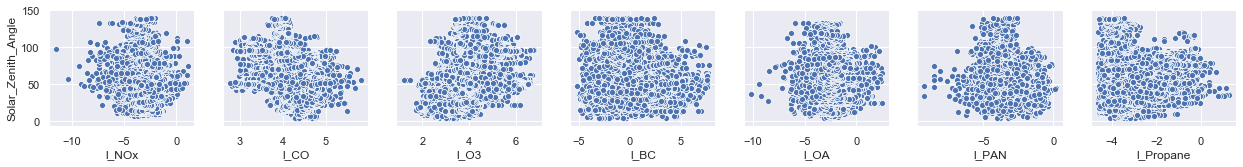

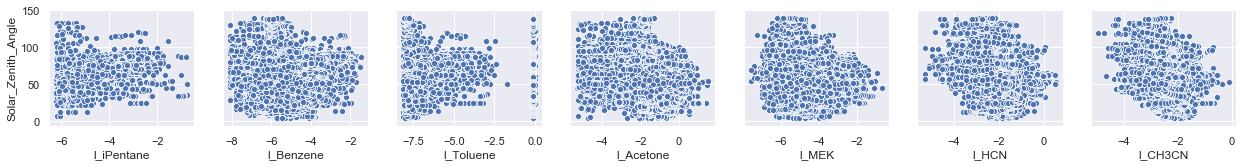

In [19]:
sns.set()
sns.pairplot(df, x_vars = log_vc[:int(len(log_vc)/2)], y_vars = ['Solar_Zenith_Angle'])
sns.pairplot(df, x_vars = log_vc[int(len(log_vc)/2):], y_vars = ['Solar_Zenith_Angle']);

Furthermore, when considering the whole period, the Southern Hemisphere tends to have lower concentration of gases. Possible reasons include fewer anthropogenic activities, population and industralized areas over there. 

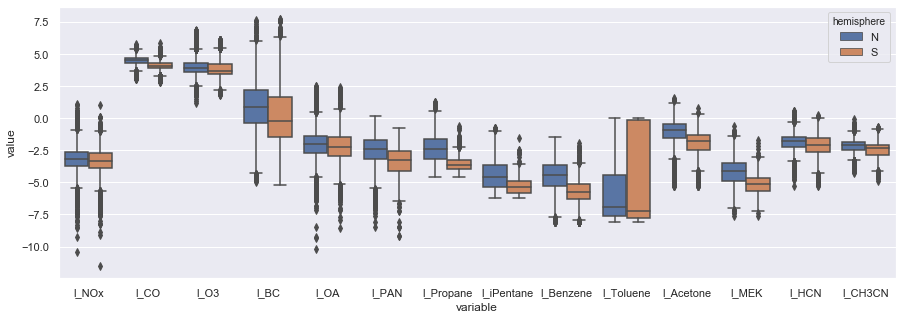

In [20]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x="variable", y="value", hue = "hemisphere",data=pd.melt(df[log_vc+["hemisphere"]],id_vars = "hemisphere"));
ax.set_xticklabels(ax.get_xticklabels());

When considering the measurement of gases at different campaigns and at different altitude layers (see the figure below), interesting patterns arise: 

* NOx is very stable among seasons and it has less variability in lower layers. NOx is constantly emmited by  antropogenic sources and has a short lifetime.

* CO, O3, BC, PAN, Propane, Pentane, Benzene, Toluene, Acetone, MEK exhibit mutimodal distributions (which is very clear for ATom-4 campaign) and changes in variability. This pattern may correspond to interhemispheric differences.

* HCN and CH3CN tend to be stable among seasons and show higher concentrations at higher layers. Fresh wilfire plumes are injected higher in the atmosphere.

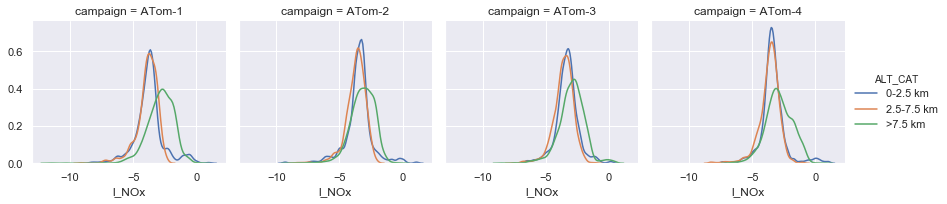

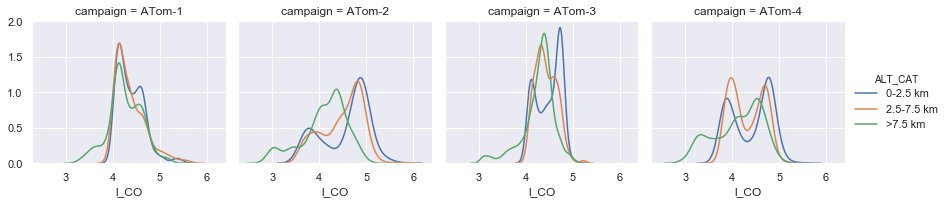

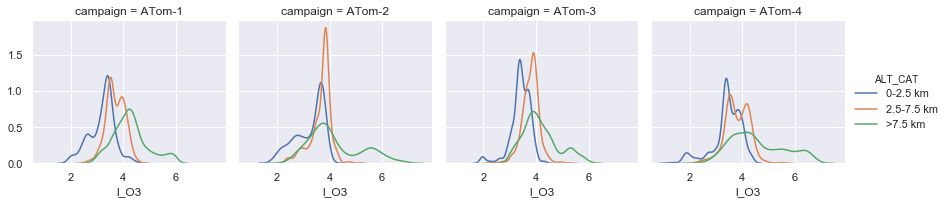

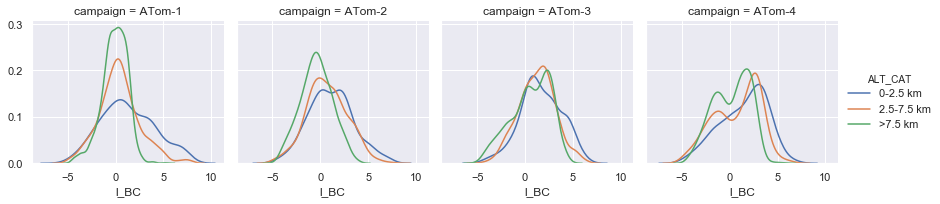

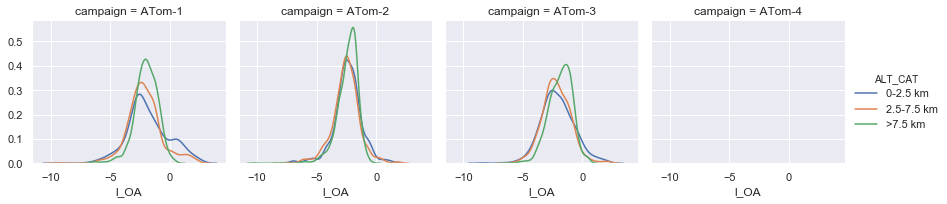

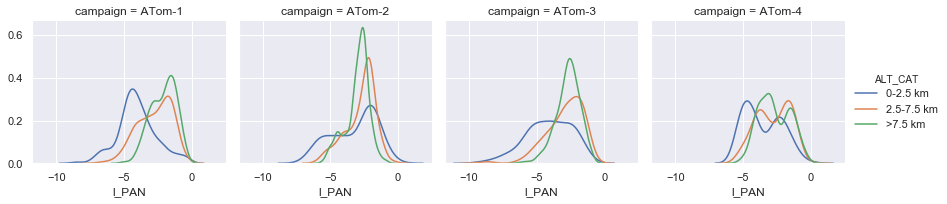

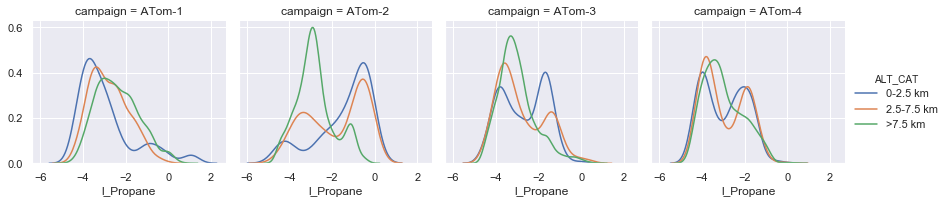

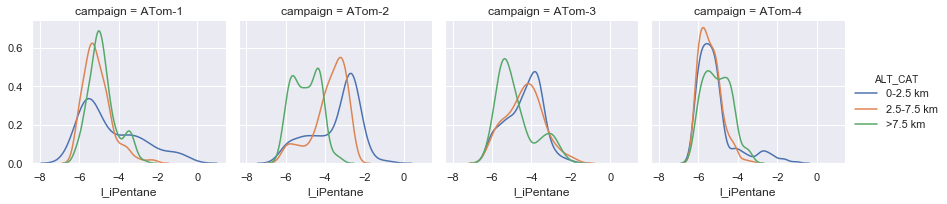

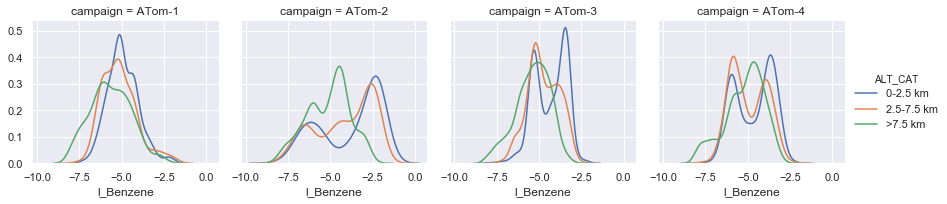

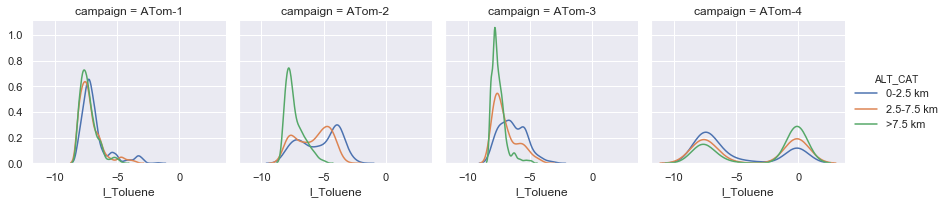

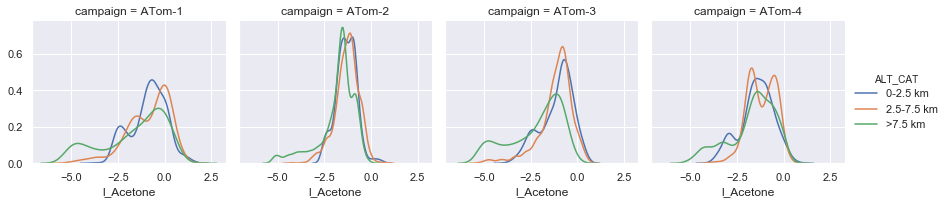

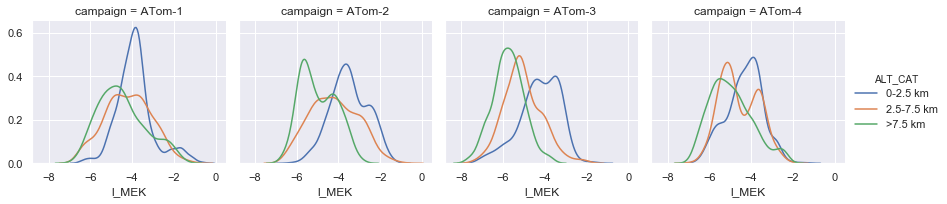

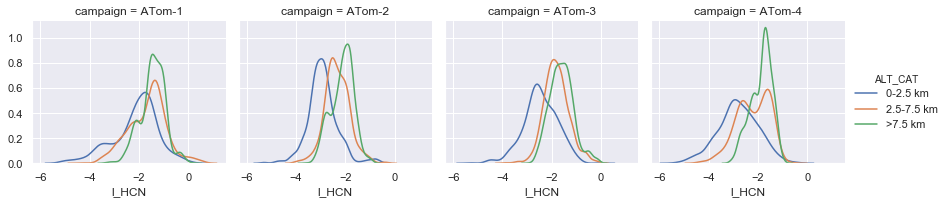

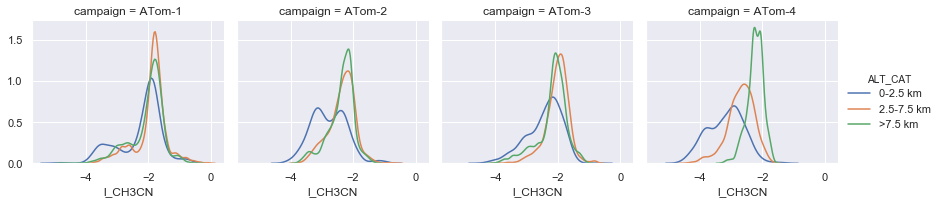

In [21]:
alt_order = sorted(df['ALT_CAT'].unique()[df['ALT_CAT'].unique() != None])
for v in log_vc:
    g = sns.FacetGrid(df, col='campaign', hue='ALT_CAT',hue_order=alt_order, col_wrap=4)
    g.map(sns.kdeplot, v)
    g.add_legend();

We have seen that when the whole period is considered, there are higher concentrations of gases in the Northern Hemishphere compared with the Southern Hemisphere. Similar results are obtained when making seasonal comparisons (note that the seasons in the Northern Hemisphere are the opposite of those in the Southern Hemisphere). 

* NOx is very similar between hemispheres across seasons. Nevertheless, for the remainin gas species, the Northern Hemishphere tend to have higher concentrations compared with the Southern Hemisphere. This species can have longer lifetimes that lets them travel further from the emission location. Once more, it should be considered the fewer industralization and people living in the South Hemisphere.

* Even though we expected higher concentrations of CO in the winter due to higher burning fossil fuels for heating, this is only true for the Sourthern Hemisphere. Interestingly, this means that CO is well mixed in the places that were sampled by AToM and that the combustion source (amazon fires) in the Southern Hemisphere may be impacting more it's distribution.

* BC is much higher in spring than in other seasons. Maybe this is due to more agricultural fires happening in the area. 

* There are gases whose distributions are unimodal in some seasons, and multimodal in others (e.g. Propane, Toluene, and  Acetone). Some of these gases may have ocean sources, and the ocean productivity may be higher in different seasons.

In [22]:
# Create a season variable
df['season'] = np.nan
df['season'].loc[np.logical_and(df['hemisphere'] == 'N',df['campaign'] == 'ATom-1')] = 'summer'
df['season'].loc[np.logical_and(df['hemisphere'] == 'S', df['campaign'] == 'ATom-1')] = 'winter'
df['season'].loc[np.logical_and(df['hemisphere'] == 'N', df['campaign'] == 'ATom-2')] = 'winter'
df['season'].loc[np.logical_and(df['hemisphere'] == 'S', df['campaign'] == 'ATom-2')] = 'summer'
df['season'].loc[np.logical_and(df['hemisphere'] == 'N', df['campaign'] == 'ATom-3')] = 'fall'
df['season'].loc[np.logical_and(df['hemisphere'] == 'S', df['campaign'] == 'ATom-3')] = 'spring'
df['season'].loc[np.logical_and(df['hemisphere'] == 'N', df['campaign'] == 'ATom-4')] = 'spring'
df['season'].loc[np.logical_and(df['hemisphere'] == 'S', df['campaign'] == 'ATom-4')] = 'fall'
df['season'].value_counts()

C:\Users\Felipe\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


fall      3387
spring    3313
summer    2809
winter    2725
Name: season, dtype: int64

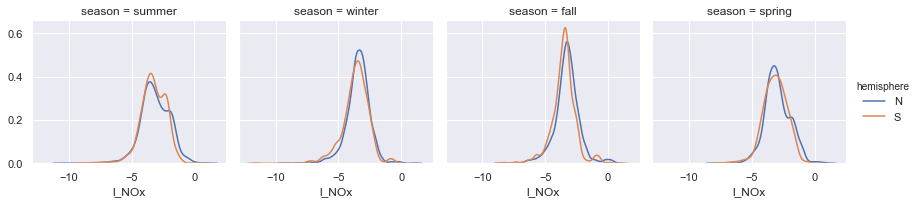

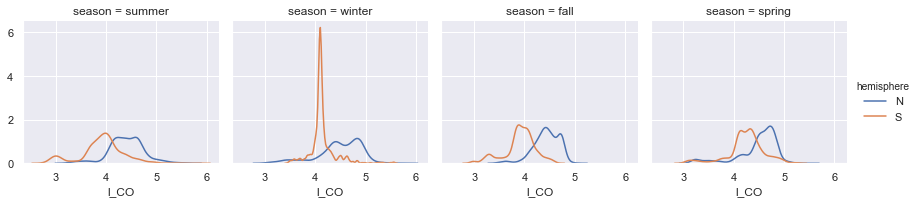

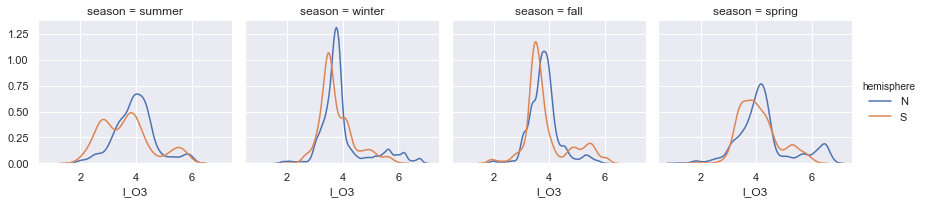

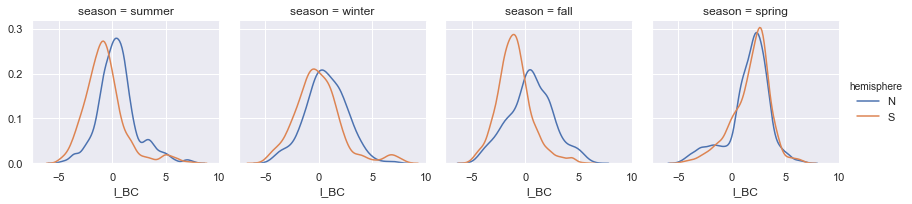

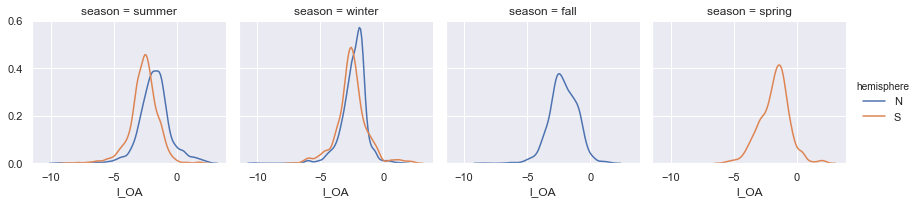

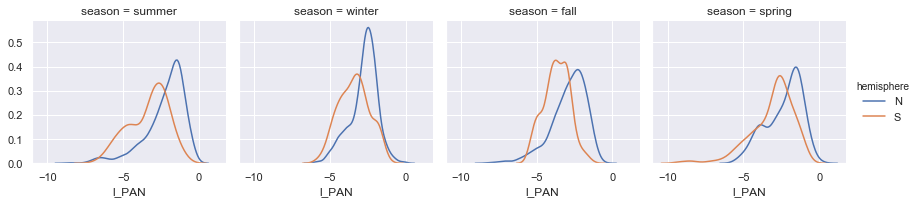

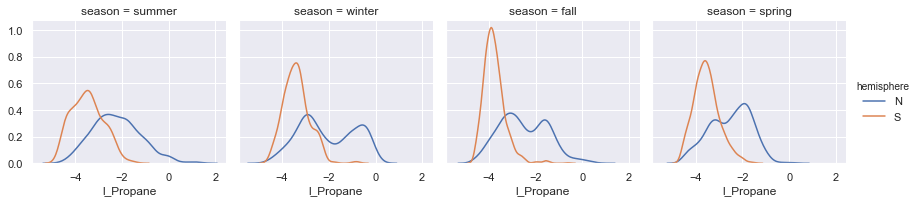

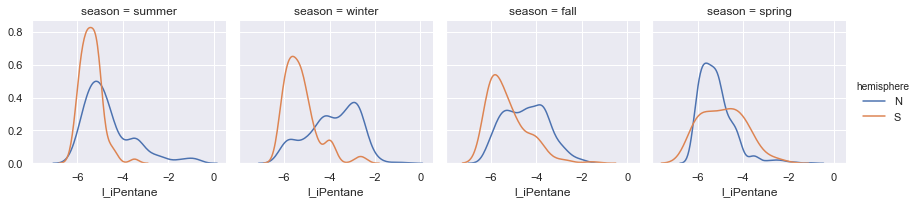

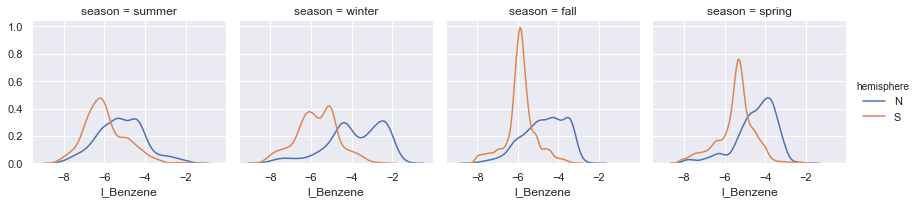

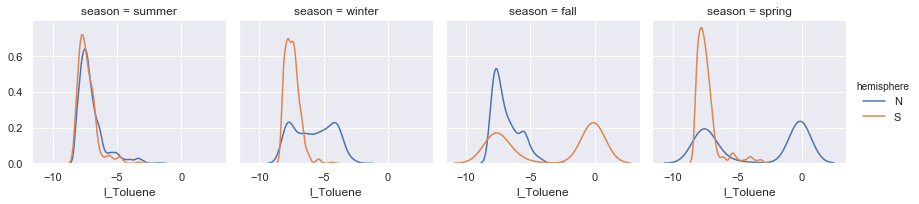

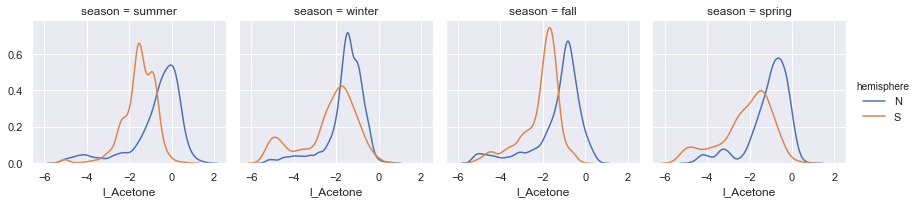

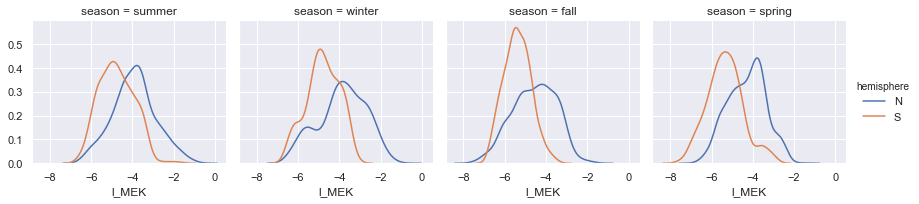

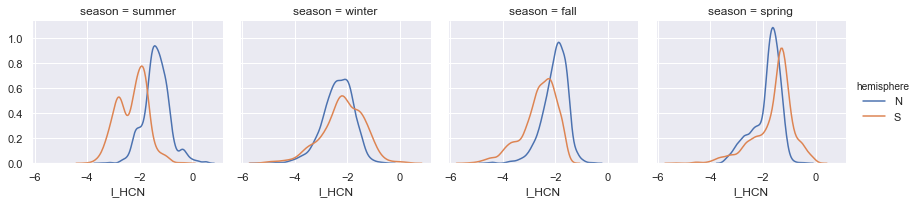

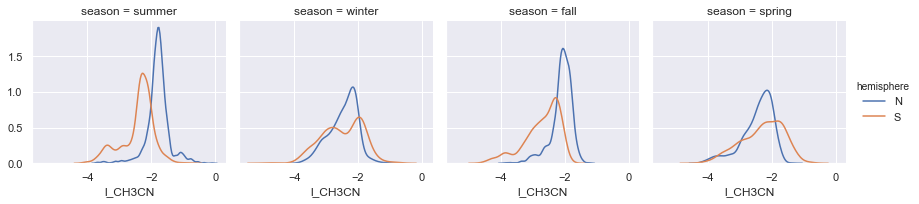

In [23]:
for v in log_vc:
    g = sns.FacetGrid(df, col='season', hue='hemisphere', col_wrap=4)
    g.map(sns.kdeplot, v)
    g.add_legend();

### 3.4. Multivariate Analysis

In order to detect other patterns that may involve relations between variables, we fist run Principal Component Analysis (PCA). We keep the first 3 principal components, which explain around 70% of the total variance. In a subsequent step, this lower dimensional projection will serve as input for a clustering algorithm. 

#### PCA

In [24]:
vars_pca = ['l_NOx','l_O3','l_BC', 'l_Propane', 'l_Benzene', 'l_Toluene', 'l_Acetone']

from sklearn.preprocessing import StandardScaler

x = df[vars_pca].copy()
x = x.dropna()
x_index = x.index.copy()
print('Number of points:', len(x))

# Standardizing the features
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
ncomp = 3 # number of components
pca = PCA(n_components = ncomp)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC'+str(n+1) for n in range(ncomp)], index = x_index)

print('Explained variance:', np.round(pca.explained_variance_ratio_,2))

Number of points: 4256
Explained variance: [0.37 0.22 0.12]


In the first component, the higher weights correspond to BC, Propane, Benzene, and Acetone; all of them having the same sign. All this components come from anthropogenic activities (e.g. fuel combustion, oil, and gas industries).
In the second component, the higher weights correspond to NOx, O3, and Toluene; all of them having the same sign. Note that NOx is a precursor for O3 and Toluene can be a precursor for NOx. 
In the third component, the higher weights correspond to NOx and Toluene, having different signs. In the presence of NOx and Toluene at the same magnitude, NOx can favor oxidation of Toluene. 

In [25]:
print('Component Coefficients:')
pd.DataFrame(np.round(pca.components_.transpose(),3), columns = ['PC'+str(n+1) for n in range(ncomp)], index = vars_pca)

Component Coefficients:


PC1    PC2    PC3
l_NOx      0.152  0.531 -0.569
l_O3       0.186  0.600 -0.103
l_BC       0.453  0.147  0.083
l_Propane  0.522 -0.062  0.025
l_Benzene  0.525 -0.248  0.106
l_Toluene -0.077  0.503  0.792
l_Acetone  0.428 -0.134  0.141

#### Clustering

The Hopkins statistic is a measure of the cluster tendency of a data set. It compares the data against (uniformly distributed) random data, which on average, should not have clusters. The statistic values lie between 0 and 1, meaning that either the data is regularly distributed or the data is highly clustered, respectively. One of the criticisms consists on utility of the test for applications since real data is never remotely uniform. Indeed, data containing just a single Gaussian will also score close to 1, as this statistic measures deviation from a uniform distribution, not multimodality. Despite this, we run this test because of the multimodality observed in some of the distributions presented above.

(Code taken from: https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/)

In [26]:
df_pc = pd.concat([principalDf,df[vi+log_vc+['ALT_CAT','season']].loc[x_index]],axis = 1)

In [27]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print (ujd, wjd)
        H = 0
 
    return H

Here, I computed the Hopkins Statistic several times to have an idea of its distribution. A sort of confidence interval is also included in dashed lines. The results suggest that the data has a clear tendency to cluster.  

In [28]:
niter = 100
Hs = [hopkins(principalDf) for i in range(niter)]

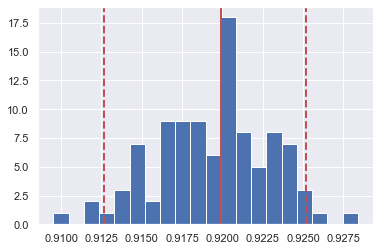

In [29]:
plt.hist(Hs, bins = 20)
plt.axvline(x = np.median(Hs), linewidth=2, color='r')
plt.axvline(x = np.quantile(Hs,0.025), linewidth=2, color='r', ls = '--')
plt.axvline(x = np.quantile(Hs,0.975), linewidth=2, color='r', ls = '--');

#### Hierachical clustering

The following dendrogram shows a nested partition of the data. Considering the ''jumps'' in the height at which groups merge, we chose a partition of 3 groups.

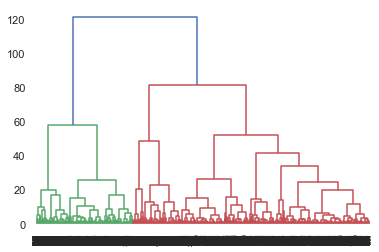

In [30]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(principalDf, method='ward'))

In [31]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(principalDf)
labels = model.labels_

In [32]:
df_pc['cluster'] = labels

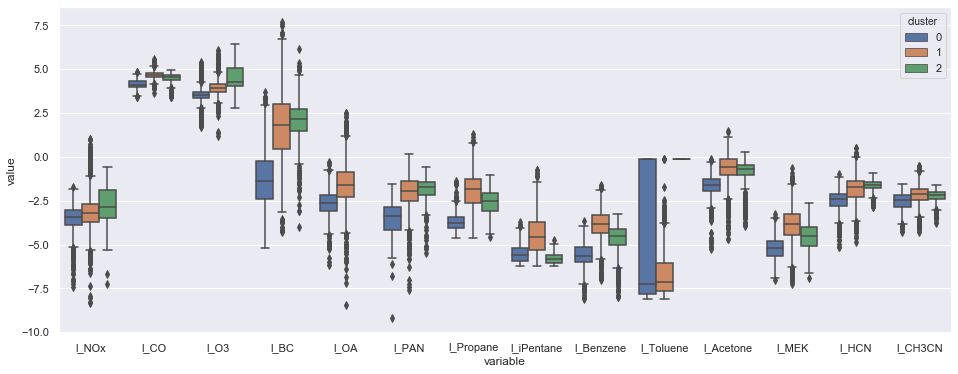

In [33]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(x="variable", y="value", hue = "cluster",data=pd.melt(df_pc[log_vc+["cluster"]],id_vars = "cluster"));
ax.set_xticklabels(ax.get_xticklabels());

*Group* 0 members are characterized by having the lowest concentrations of gases, except for Toluene. The main locations correspond to the Sourthern Hemisphere over the Pacific Ocean during ATom-1 (Jul-Aug 2016) and ATom-4 (Apr-May 2018) campaigns, and at all all altitude layers.

*Group 1* members have the highest concentrations of CO, BC, OA, PAN, Propane, Pentane, Benzene, Acetone, MEK, and HCN; and middle concentrations of O3. The main locations correspond to the Northern Hemisphere during all campaigns, and at all all altitude layers.

*Group 2* members have highest concentrations of NOx, CO, O3, BC, PAN, Toluene; middle concentrations of Propane, Benzene, Acetone, MEK; and low concentration of Pentane. The main locations correspond to the Northern Hemisphere during ATom-4 (Apr-May 2018) campaign, and mainly at higher altitude layers. This is definitely wildfire emissions driven.

Furthermore, in Fall  and Winter, *Group 0* members mainly lie in the South. During Summer and Spring in the South, less combustion is needed to warm up houses and public areas; then less combustion results in less air pollution. *Group 1* members lie in the North, so the converse analysis holds. In Fall, there are also very few members of *Group 3* in the Atlantic near Brazil (once again, it is an indication of wildfires). Contrarily, in Spring and Summer almost all the points are concentrated in the North. In the latter case, almost all the points correspond to *Group 1*. Spring can have emissions of VOCs (Volatile Organic Compunds) as the temperature starts to increase. Furthermore, in Summer, most of the western US was light up in fire.

In [34]:
gdf_pc = gpd.GeoDataFrame(df_pc, geometry = df.apply(lambda row: Point(row['G_LONG'], row['G_LAT']), axis=1))

In [35]:
# Parameters of the legend
from matplotlib.lines import Line2D

labels = list(range(gdf_pc.cluster.max()+1))
cm = [plt.get_cmap('tab10')(i) for i in range(10)]
colors = dict(zip(labels,cm))
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], label=i,markersize=15) for i in labels]

In [36]:
def map_cluster(variable=None):
    if variable is None:
        fig, ax = plt.subplots(figsize = (12,10))
        ax.set_aspect('equal')
        world.plot(ax=ax, color='blue', edgecolor='black', alpha = 0.2)
        gdf_pc.plot(ax=ax, marker='o', markersize=20, column = 'cluster', 
                                           color=gdf_pc['cluster'].apply(lambda x: colors[x]), 
                                           alpha = 0.3)
        ax.legend(handles=legend_elements, loc= 'upper right', title = 'Cluster');
    else: 
        cs = sorted(df[variable].unique()[df[variable].unique() != None])
        for i,c in enumerate(cs):
            fig, ax = plt.subplots(figsize = (12,10))
            ax.set_aspect('equal')
            world.plot(ax=ax, color='blue', edgecolor='black', alpha = 0.2)
            gdf_pc[gdf_pc[variable] == c].plot(ax=ax, marker='x', markersize=20, column = 'cluster', 
                                               color=gdf_pc['cluster'][gdf_pc[variable] == c].apply(lambda x: colors[x]), 
                                               alpha = 0.3)
            ax.legend(handles=legend_elements, loc= 'upper right', title = 'Cluster')
            ax.set_title(c);

C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


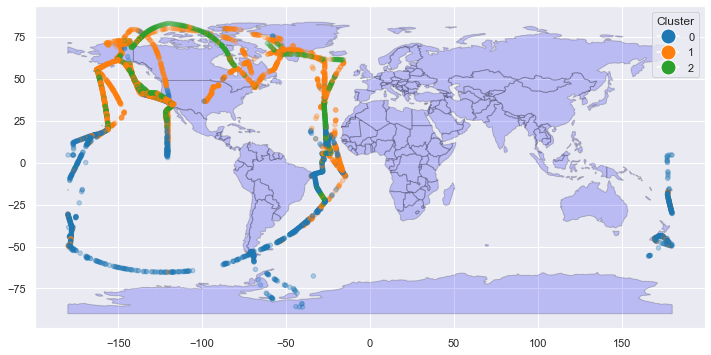

In [37]:
# Map with cluster members
map_cluster()

C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


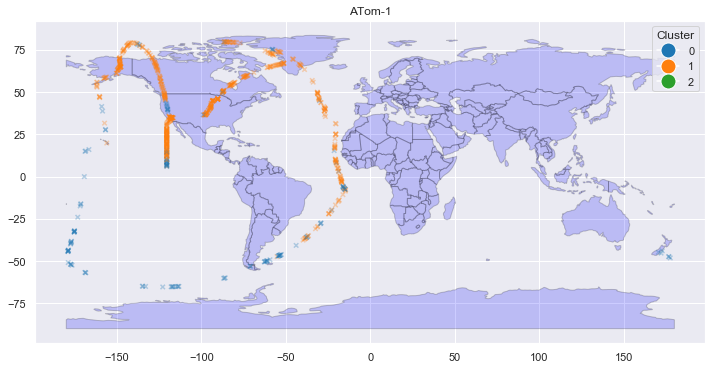

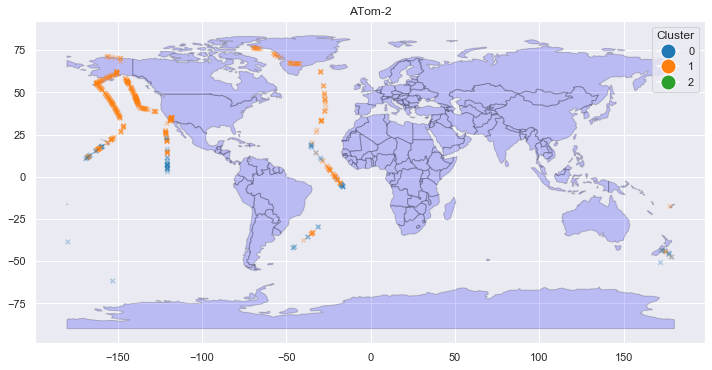

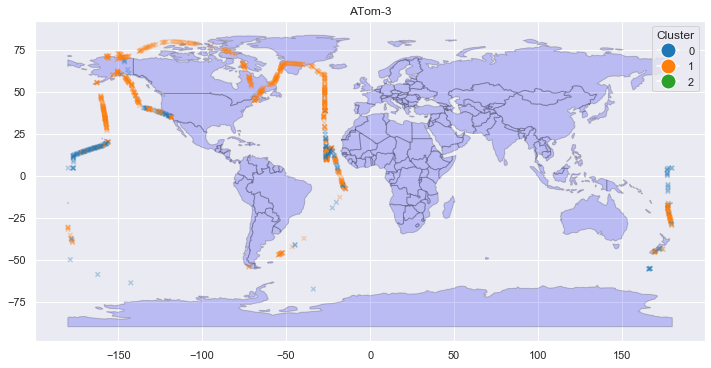

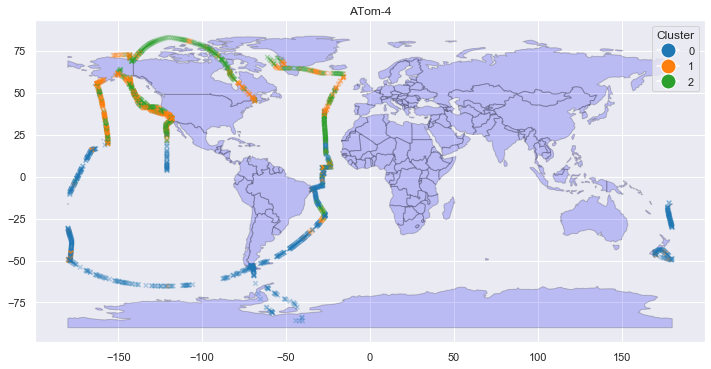

In [38]:
# Clusters are plotted in maps by campaign
map_cluster('campaign')

C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


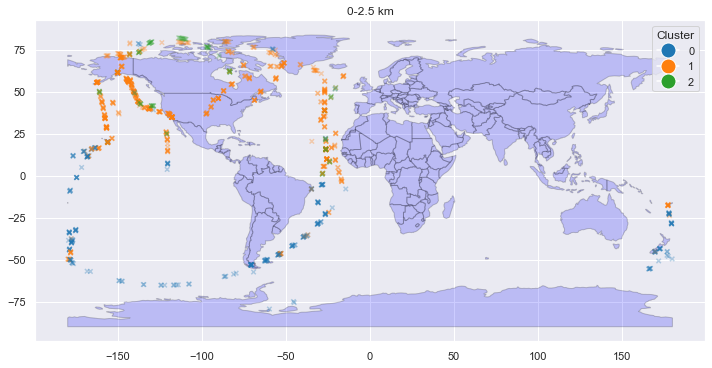

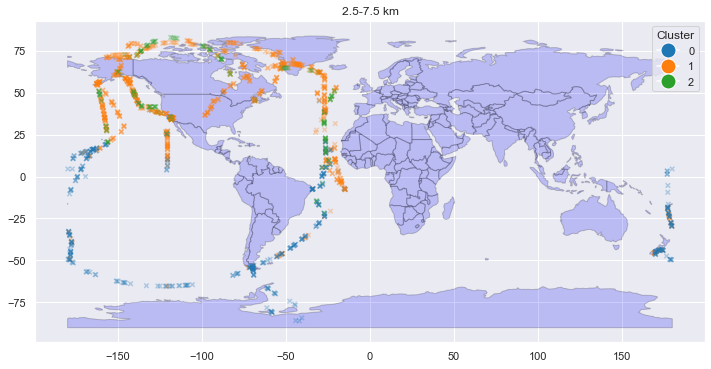

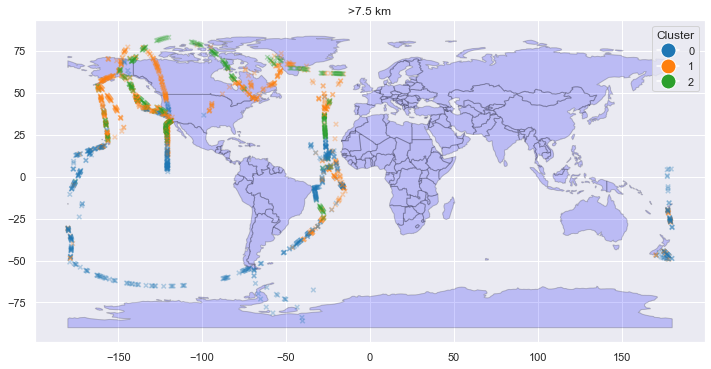

In [39]:
# Clusters are plotted in maps by altitude layer        
map_cluster('ALT_CAT')

C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
C:\Users\Felipe\Anaconda3\lib\site-packages\geopandas\plotting.py:471: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


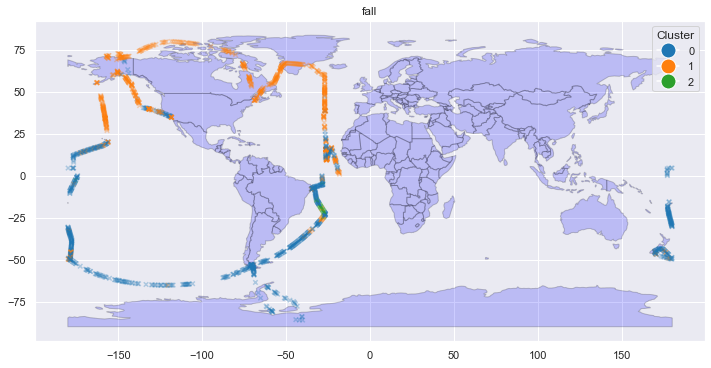

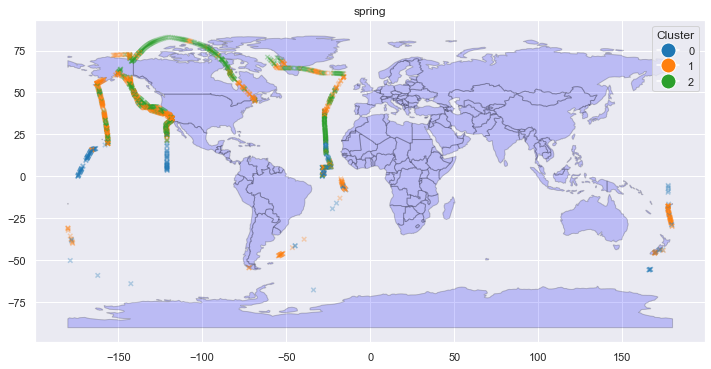

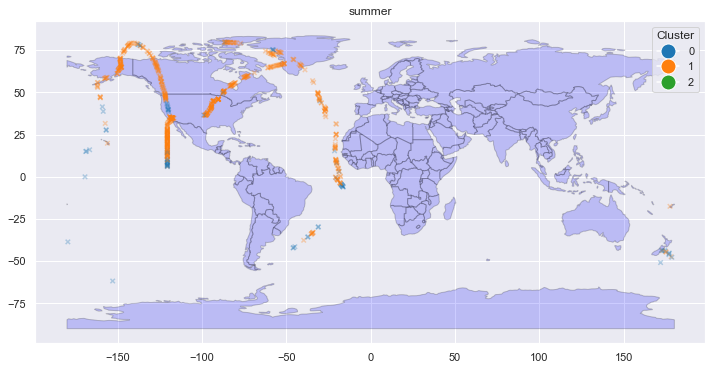

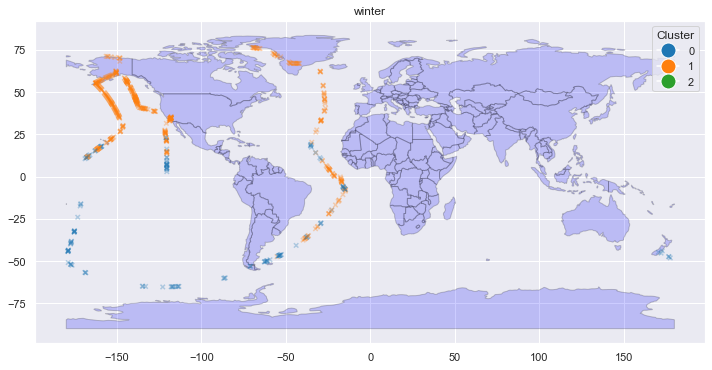

In [40]:
# Clusters are plotted in maps by altitude layer       
map_cluster('season');